In [1]:
!pip install gdown

In [16]:
import gdown, torch, os, torchvision, cv2, time, warnings, random
warnings.filterwarnings("ignore")
from zipfile import ZipFile
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from PIL import Image

In [3]:
file_id = "1mH1dnfo01foIrhbT5VTiv5wyR_7QStUO"
output_file = "PistolDataset.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mH1dnfo01foIrhbT5VTiv5wyR_7QStUO
To: /content/PistolDataset.zip
100%|██████████| 21.2M/21.2M [00:00<00:00, 28.5MB/s]


'PistolDataset.zip'

In [4]:
z = ZipFile(output_file)
z.extractall()
z.close()

In [5]:
train_images_dir = "/content/Pistols_Datasets/train/images"
train_annotations_dir = "/content/Pistols_Datasets/train/labels"

In [6]:
print(f"Before: {len(os.listdir(train_images_dir))}")

images = set(os.listdir(train_images_dir))
annotations = os.listdir(train_annotations_dir)

for annotation in annotations:
  annotation_filename = os.path.join(train_annotations_dir, annotation)
  image_filename = annotation[:-4] + '.jpg'

  # Delete annotation files for which there are no images
  if image_filename not in images:
    os.remove(annotation_filename)
    continue

  with open(annotation_filename, "r") as f:
    for line in f:
      data = line.strip().split()
      if len(data) < 5:
        os.remove(annotation_filename)

      break

print(f"After: {len(os.listdir(train_images_dir))}")

Before: 917
After: 917


In [7]:
class CustomDataset:
  def __init__(self, images_dir, annotations_dir, transform=None):
    self.images_dir = images_dir
    self.images = os.listdir(images_dir)
    self.annotations_dir = annotations_dir
    self.annotations = os.listdir(annotations_dir)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    # Get annotation filename
    annotation = self.annotations[index]
    # Fetch image filepath
    image_filename = os.path.join(self.images_dir, annotation[:-4] + '.jpg')

    # Load image
    image = cv2.imread(image_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image channels
    height, width, _ = image.shape

    # Parse the annotation file
    annotation_file = os.path.join(self.annotations_dir, annotation)
    boxes, labels = [], []

    with open(annotation_file, "r") as f:
      for line in f:
        data = line.strip().split()
        class_idx = int(data[0])
        x_center = float(data[1]) * width
        y_center = float(data[2]) * height
        box_width = float(data[3]) * width
        box_height = float(data[4]) * height

        x_min = x_center - box_width / 2
        y_min = y_center - box_height / 2
        x_max = x_center + box_width / 2
        y_max = y_center + box_height / 2

        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(int(class_idx) + 1)

    # Convert to PyTorch tensors
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    # Apply image transformations
    if self.transform:
      image = self.transform(image)

    # Create target dictionary
    target = {"boxes": boxes, "labels": labels}

    return image, target

In [8]:
train_dataset = CustomDataset(train_images_dir, train_annotations_dir, transform=transforms.ToTensor())
train_data_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))

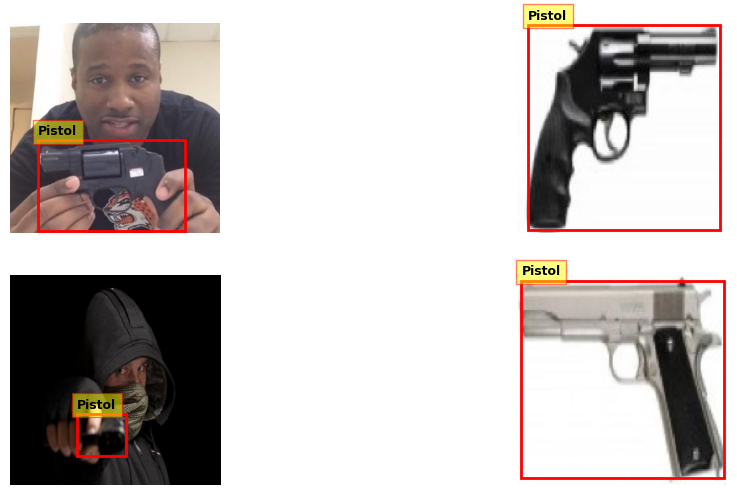

In [9]:
# Create a plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
ax = ax.ravel()

# Get a batch of images from the data loader
images, targets = next(iter(train_data_loader))

# Define the class names
class_names = ["bg", "Pistol"]

for i in range(4):
  image = images[i].permute(1, 2, 0).numpy() # Convert from (C,H,W) to (H,W,C) for visualization
  target = targets[i]

  boxes = target["boxes"].numpy()
  labels = target["labels"].numpy()

  ax[i].imshow(image)

  # Add bounding boxes to the image
  for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = box
    width, height = xmax - xmin, ymax - ymin
    rectangle = patches.Rectangle(
        (xmin, ymin),
        width=width,
        height=height,
        edgecolor="red",
        facecolor="none",
        linewidth=2
    )
    ax[i].add_patch(rectangle)
    ax[i].text(
        xmin,
        ymin - 10,
        f"{class_names[label]}",
        color="black",
        fontsize=9,
        fontweight="bold",
        bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red")
    )
    ax[i].axis("off")

plt.show()

In [10]:
num_classes = 2 # 1 for background and other for Pistol class

# Load the pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True, weights="COCO_V1")

# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Make the backbone model's parameters trainable
for param in model.backbone.parameters():
  param.requires_grad = True

In [11]:
# Move model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params=params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.0005)
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.1)
num_epochs = 20

In [12]:
train_losses = []

start_time = time.time()

for i in range(1, num_epochs + 1):
  train_running_loss = 0.0

  for images, targets in train_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Make predictions on each batch of images
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad() # Reset gradients
    losses.backward() # Perform backpropagation
    optimizer.step() # Update weights and biases

    train_running_loss += losses.item()

  avg_train_loss = train_running_loss / len(train_data_loader)
  train_losses.append(avg_train_loss)

  scheduler.step(avg_train_loss) # Optimize learning rate using StepLR

  print(f"Epoch {i} -> Training Loss: {avg_train_loss}")

print(f"Total time taken: {(time.time() - start_time) / 60} minutes.")

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 -> Training Loss: 0.1976825543395851
Epoch 2 -> Training Loss: 0.12126887081109959
Epoch 3 -> Training Loss: 0.09934409628419773
Epoch 4 -> Training Loss: 0.08373919419296409
Epoch 5 -> Training Loss: 0.07252800088861715
Epoch 6 -> Training Loss: 0.06460997254142295
Epoch 7 -> Training Loss: 0.05818601102446732
Epoch 8 -> Training Loss: 0.052528728593302806
Epoch 9 -> Training Loss: 0.04874056620604318
Epoch 10 -> Training Loss: 0.044871277750834174
Epoch 11 -> Training Loss: 0.041614950172927066
Epoch 12 -> Training Loss: 0.03948962901435468
Epoch 13 -> Training Loss: 0.037383884122676174
Epoch 14 -> Training Loss: 0.03554838002537904
Epoch 15 -> Training Loss: 0.03356903834349435
Epoch 16 -> Training Loss: 0.032446705784810626
Epoch 17 -> Training Loss: 0.031163678796071074
Epoch 18 -> Training Loss: 0.029568218873084886
Epoch 19 -> Training Loss: 0.02877575619470166
Epoch 20 -> Training Loss: 0.027496256902004065
Total time taken: 71.7445642709732 minutes.


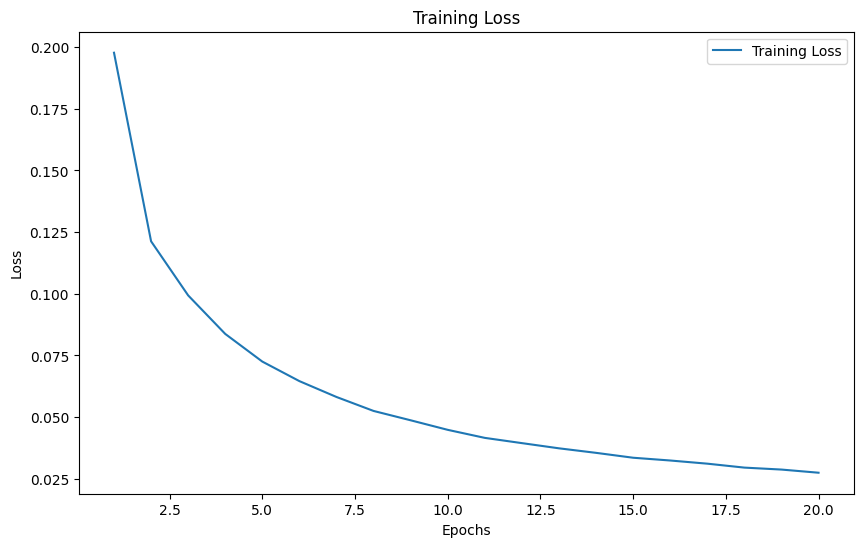

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show();

In [14]:
torch.save(model.state_dict(), "pistol_object_detector.pth")

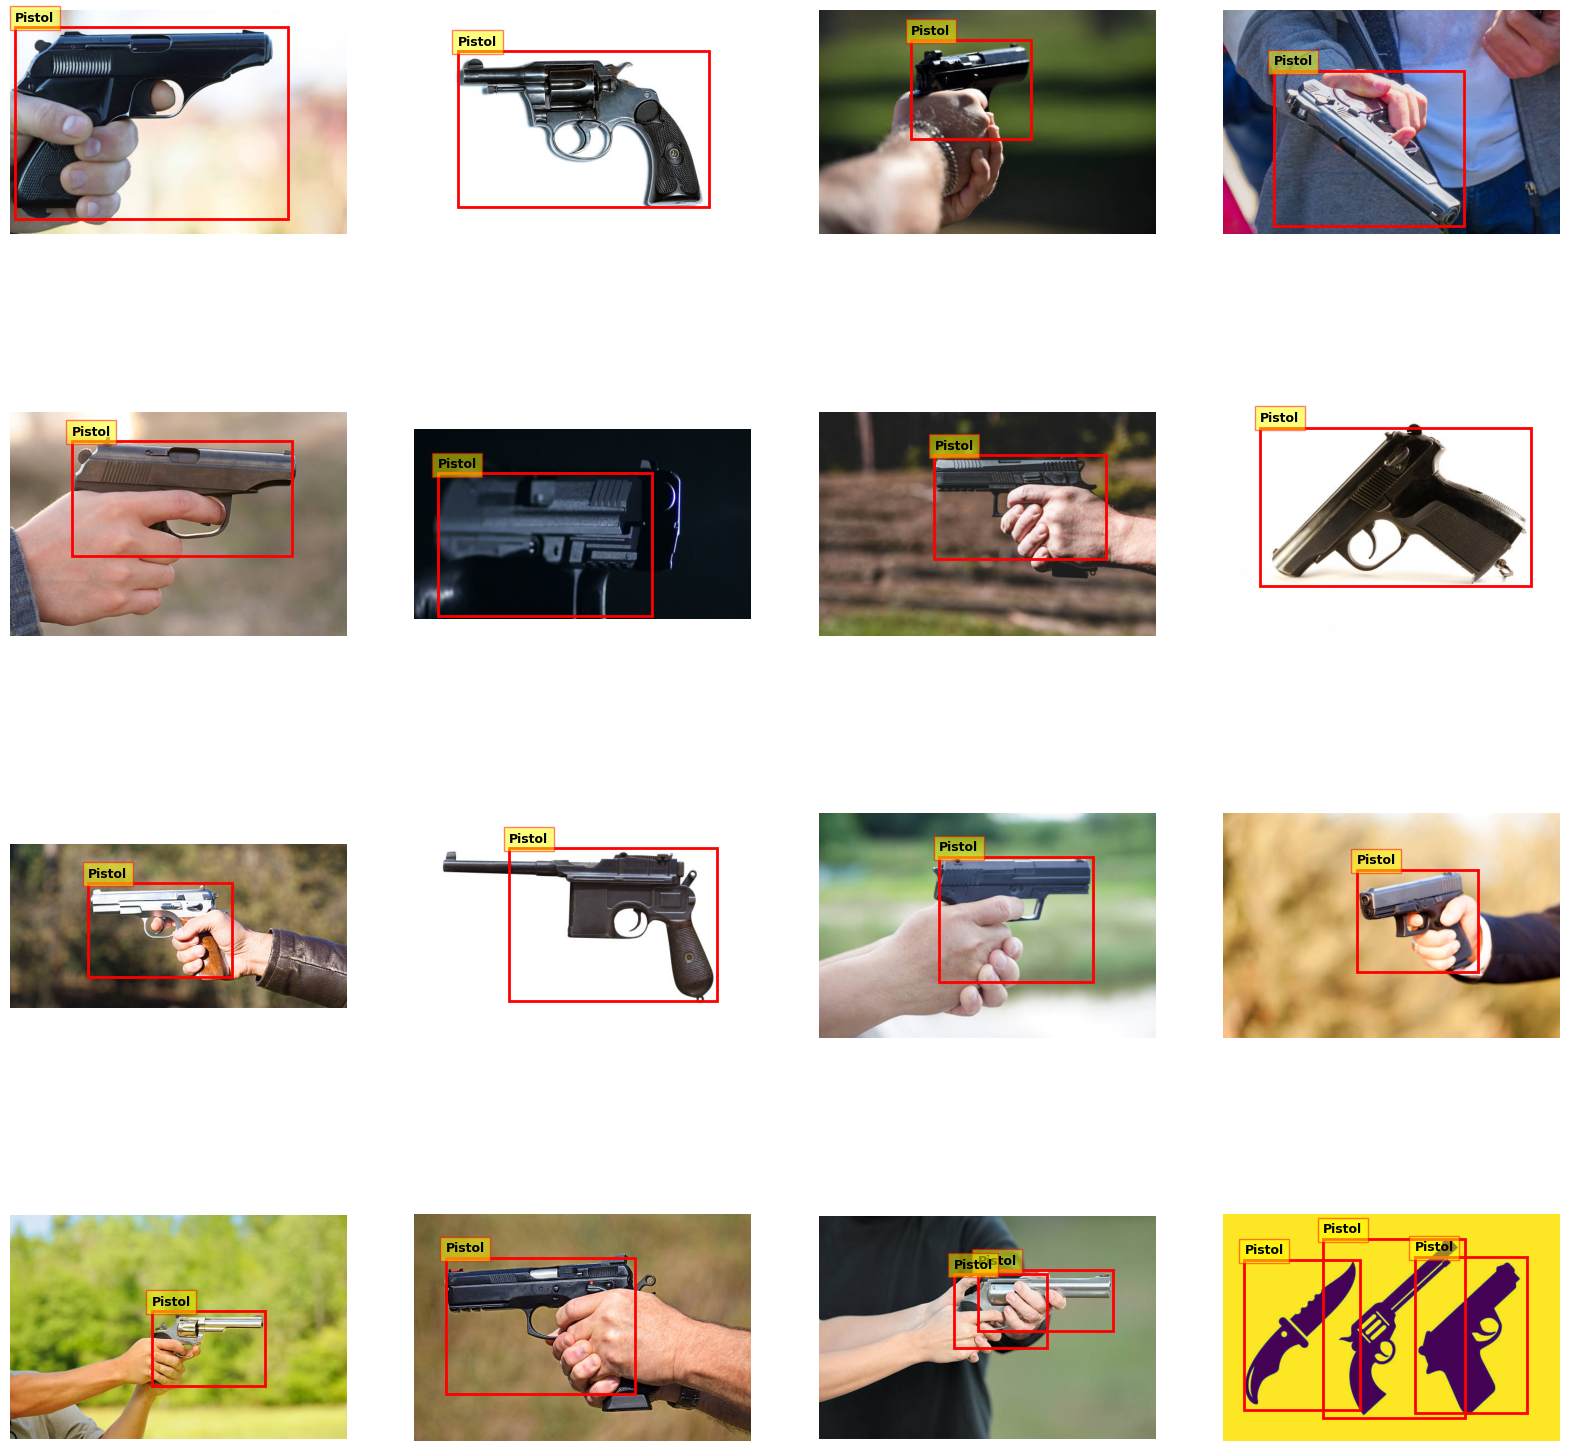

In [19]:
# Recreate the model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2 # 1 for Pistol + 1 for background

model = fasterrcnn_resnet50_fpn(pretrained=False)

# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained model weights
model.load_state_dict(torch.load('pistol_object_detector.pth'))
model.to(device) # Move model to the correct device
model.eval() # Set model to evaluation mode

# Create a plot
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
axes = axes.ravel()

transform = transforms.ToTensor()

test_images_dir = "/content/Pistols_Datasets/test"
test_images = os.listdir(test_images_dir)

class_names = ['bg', 'Pistol']

for i in range(16):
  test_img_path = os.path.join(test_images_dir, random.choice(test_images)) # Select a random test image
  image = Image.open(test_img_path) # Load the random test image
  image = transform(image) # Apply image transformations
  image = image.unsqueeze(0).to(device) # Add a batch dimension -> (1, C, H, W)

  with torch.no_grad():
    predictions = model(image)[0] # Get the first image's predictions

  # Convert image to Numpy for visualization
  image_np = image.squeeze(0).cpu().permute(1, 2, 0).numpy() # Convert (C, H, W) -> (H, W, C) for visualization

  # Extract predictions
  boxes = predictions["boxes"].cpu().numpy()
  labels = predictions["labels"].cpu().numpy()
  scores = predictions["scores"].cpu().numpy()

  axes[i].imshow(image_np)
  axes[i].axis("off")

  colors = [
      (1, 0, 0), # RED
      (0, 1, 0), # GREEN
      (0, 0, 1), # BLUE
      (1, 1, 0), # YELLOW
      (1, 0, 1), # MAGENTA
      (0, 1, 1), # CYAN
      (0.5, 0, 0), # MAROON
      (0, 0.5, 0), # OLIVE
      (0, 0, 0.5), # NAVY
      (0.5, 0.5, 0), # OLIVE D
      (0, 0.5, 0.5), # TEAL
      (0.5, 0, 0.5), # PURPLE
  ]

  for box, label, score in zip(boxes, labels, scores):
    if score > 0.85:
      color = random.choice(colors)
      xmin, ymin, xmax, ymax = box
      width, height = xmax - xmin, ymax - ymin
      rectangle = patches.Rectangle(
          (xmin, ymin),
          width=width,
          height=height,
          edgecolor="red",
          facecolor="none",
          linewidth=2
      )
      axes[i].add_patch(rectangle)
      axes[i].text(
          xmin,
          ymin - 10,
          f"{class_names[label]}",
          color="black",
          fontsize=9,
          fontweight="bold",
          bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red")
      )
